In [103]:
# imports
import deepxde as dde
import numpy as np
import os
import sys
import tensorflow as tf
from matplotlib import pyplot as plt

from typing import Callable, Dict, List, Tuple

In [104]:
# config
tf.get_logger().setLevel('ERROR')

dde.config.set_random_seed(7913)
if dde.backend.backend_name != 'tensorflow':
    raise Exception("set backend tensorflow with: python -m deepxde.backend.set_default_backend tensorflow")

DTYPE: str = "float32"
dde.config.set_default_float(DTYPE)
tf.keras.backend.set_floatx(DTYPE)
if DTYPE == "float32":
    dde.config.real.set_float32()
    DTYPE = np.float32
elif DTYPE == "float64":
    dde.config.real.set_float64()
    DTYPE = np.float64
else:
    raise Exception("Choose DTYPE: float32 or float64")


Set the default float type to float32


In [105]:
# helper functions
def get_grad(model: tf.keras.Sequential, X_r: tf.Tensor, r: int, d: int = 1) -> np.ndarray:
    """Calculate the dth derivative from the model at r.

    Args:
        model (tf.keras.Sequential): model
        X_r (tf.Tensor): Input Matrix
        r (int): index of feature
        d (int): which derivative, d > 0. Default is 1. 

    Returns:
        np.ndarray: gradient
    """
    with tf.GradientTape(persistent=True) as tape:
        cols = []
        for i in range(X_r.shape[1]):
            cols.append(X_r[:, i])
            if r == i:
                tape.watch(cols[i])

        X = tf.stack(cols, axis=1)
        u = model(X)

        G = np.empty((X_r.shape[0], u.shape[1]), dtype= DTYPE)
        for k in range(u.shape[1]):
            u_x = u[:,k]
            x = cols[r]
            for _ in range(d):
                u_x = tape.gradient(u_x, x)
            G[:, k] = u_x.numpy()
    del tape
    return G

In [106]:
# geometry classes
class Geometry:
    def __init__(self, num_dom: int, num_bnd: int, num_tst: int) -> None:
        self.num_dom: int = num_dom
        self.num_bnd: int = num_bnd
        self.num_tst: int = num_tst
        self.geom: dde.geometry.Geometry
        self.dirichlet_bcs: List[dde.icbc.boundary_conditions.BC]
        self.data_dom: dde.data.Data
        self.data_test: dde.data.Data
        self.dirichlet_bcs: List[dde.data.Data]

    def exact_sol(r: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def pde(r, T):
        raise NotImplementedError

    def phi(r):
        raise NotImplementedError

    def full_pde(r, T):
        raise NotImplementedError

    def get_loss(self, model: tf.keras.Sequential, X_r: tf.Tensor) -> np.ndarray:
        raise NotImplementedError


class RectHole(Geometry):
    a = 0.4
    b = 1.0

    def __init__(self, num_dom: int, num_bnd: int, num_tst: int) -> None:
        a = RectHole.a
        b = RectHole.b

        super().__init__(num_dom, num_bnd, num_tst)

        self.geom: dde.geometry.Geometry = dde.geometry.Rectangle([-b, -b], [b, b]) - dde.geometry.Disk([0, 0], a / 2)

        self.dirichlet_bcs: List[dde.icbc.boundary_conditions.DirichletBC] = []
        self.dirichlet_bcs.append(dde.DirichletBC(geom=self.geom, func=RectHole._exact_sol, on_boundary=RectHole._ver_boundary))
        self.dirichlet_bcs.append(dde.DirichletBC(geom=self.geom, func=RectHole._exact_sol, on_boundary=RectHole._int_boundary))

        self.neumann_bcs: List[dde.icbc.boundary_conditions.NeumannBC] = []
        self.neumann_bcs.append(dde.NeumannBC(geom=self.geom, func=RectHole._exact_grad_n, on_boundary=RectHole._hor_boundary))

        self.data_dom = dde.data.PDE(self.geom, RectHole.pde, [], num_domain=num_dom, num_boundary=0, num_test=num_tst, solution=None)

        self.data_dirichlet: List[dde.data.PDE] = []
        for bc in self.dirichlet_bcs:
            self.data_dirichlet.append(dde.data.PDE(self.geom, RectHole.pde, [bc], num_domain=0, num_boundary=num_bnd, num_test=num_tst, solution=__class__._exact_sol))

        self.data_neumann: List[dde.data.PDE] = []
        for bc in self.neumann_bcs:
            self.data_neumann.append(dde.data.PDE(self.geom, RectHole.pde, [bc], num_domain=0, num_boundary=num_bnd, num_test=num_tst, solution=__class__._exact_grad_n))

        self.data_test = dde.data.PDE(
            self.geom, 
            RectHole.full_pde, 
            self.dirichlet_bcs + self.neumann_bcs, 
            num_domain=num_dom, 
            num_boundary=num_bnd, 
            num_test=num_tst, 
            solution=RectHole._exact_sol)

    def _ver_boundary(r, on_boundary):
        x, _ = r
        return on_boundary and np.isclose(x**2, RectHole.b**2)

    def _int_boundary(r, on_boundary):
        x, y = r
        return on_boundary and np.isclose((x**2 + y**2), (RectHole.a / 2)**2)

    def _exact_grad_n(r):
        # Q&A: here just on horizontal boundary defined? @Sacchetti
        a = RectHole.a
        b = RectHole.b
        x = r[:, 0:1]
        return b * (2 - a / (x**2 + b**2)**0.5)

    def _hor_boundary(r, on_boundary):
        _, y = r
        return on_boundary and np.isclose(y**2, RectHole.b**2)

    def _exact_sol(r: np.ndarray) -> np.ndarray:
        x = r[:, 0:1]
        y = r[:, 1:]
        return ((x**2 + y**2)**0.5 - (RectHole.a / 2))**2

    def _phi(r):
        x = r[:, 0:1]
        y = r[:, 1:]
        return (RectHole.a / (x**2 + y**2)**0.5) - 4

    def exact_sol(self, r: np.ndarray) -> np.ndarray:
        return __class__._exact_sol(r)

    def pde(r, T):
        dT_xx = dde.grad.hessian(T, r, i=0, j=0)
        dT_yy = dde.grad.hessian(T, r, i=1, j=1)
        return dT_xx + dT_yy

    def phi(self, r):
        return __class__._phi(r)

    def full_pde(r, T):
        return RectHole._pde(r, T) + RectHole._phi(r)

    def get_loss(self, model: tf.keras.Sequential, X_r: tf.Tensor) -> np.ndarray:
        u_xx = get_grad(model, X_r, 0, 2)
        u_yy = get_grad(model, X_r, 1, 2)
        return u_xx + u_yy


In [107]:
def _init_model(layers: List[int], seed: Tuple[int, int] = None) -> tf.keras.Sequential:
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))
    seed_w = seed_b = None
    if seed is not None:
        seed_w, seed_b = seed
    initializer_w = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=seed_w)
    initializer_b = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=seed_b)
    for layer in layers:
        model.add(tf.keras.layers.Dense(layer,
                    activation=tf.keras.activations.get('tanh'),
                    kernel_initializer=initializer_w,
                    use_bias=True,
                    bias_initializer=initializer_b))
    return model

class PdeELM:
    def __init__(self, layers: List[int], seed: Tuple[int, int] = None, rcond: float = 1e-10) -> None:
        """Initialize PdeELM.

        Args:
            layers (List[int]): hiddenlayer sizes without bias
            seed (Tuple[int, int], optional): Seed for weight, bias init. Defaults to None.
            rcond (float): threshold for numpy.linalg.pinv. Default is 1e-10
        """
        self.seed = seed
        self.layers = layers
        self.rcond: float = rcond
        self.model: tf.keras.Sequential = _init_model(layers=layers, seed=seed)

    def fit(
        self, 
        X_dom: np.ndarray, phi_dom: np.ndarray, 
        get_loss: Callable,
        dirichlet_bcs: List[Tuple[np.ndarray, np.ndarray]] = [],
        neumann_bcs: List[Tuple[np.ndarray, np.ndarray, np.ndarray]] = []
        ) -> None:
        """Fit model to PDE-Loss and given boundary conditions.

        Args:
            X_dom (np.ndarray): Input on domain.
            phi_dom (np.ndarray): not linear part of pde
            dirichlet_bcs (List[Tuple[np.ndarray, np.ndarray]], optional): Containes tuple of points on boundary and solution. Defaults to [].
            neumann_bcs (List[Tuple[np.ndarray, np.ndarray, np.ndarray]], optional): Containes tuple of points on boundary, unit normal and solution. Defaults to [].
        """
        X_dom_tf = tf.convert_to_tensor(X_dom)
        loss = get_loss(self.model, X_dom_tf)
        # TO DO: replace zeros with coefficent of T(x) * HL in PDE in order to use PDE with form of PDE(T, r) = a*T(r) + ...
        A = np.c_[np.zeros((loss.shape[0], 1), dtype=DTYPE), loss]
        b = -phi_dom

        for X_bc, y_bc in dirichlet_bcs:
            A_bc = self.model(X_bc)
            A_bc = np.c_[np.ones((A_bc.shape[0], 1), dtype=DTYPE), A_bc]
            A = np.concatenate([A, A_bc])
            b = np.concatenate([b, y_bc])

        for X_bc, u_normal, y_bc in neumann_bcs:
            X_bc_tf = tf.convert_to_tensor(X_bc)
            T_x = get_grad(self.model, X_bc_tf, 0, 1)
            T_y = get_grad(self.model, X_bc_tf, 1, 1)
            grad = np.dstack((T_x, T_y))
            A_bc = np.zeros((T_x.shape[0], T_x.shape[1] + 1), dtype=DTYPE)
            for row in range(T_x.shape[0]):
                for col in range(T_x.shape[1]):
                    A_bc[row][col+1] = np.inner(grad[row][col], u_normal[row])
            A = np.concatenate([A, A_bc])
            b = np.concatenate([b, y_bc])

        A_inv = np.linalg.pinv(A, rcond=self.rcond)
        w_out = A_inv.dot(b)

        self.full_model_: tf.keras.Sequential = _init_model(layers=self.layers, seed=None)
        self.full_model_.add(tf.keras.layers.Dense(
                    units=1,
                    ))
        for i, layer in enumerate(self.model.layers):
            self.full_model_.layers[i].set_weights(layer.get_weights())
        self.full_model_.layers[-1].set_weights([w_out[1:,:], w_out[0,:].flatten()])

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict output, use only after fit!

        Args:
            X (np.ndarray): Input Matrix

        Returns:
            np.ndarray: y predicted
        """
        return self.full_model_(X).numpy()

    def get_accuracy(self, X: np.ndarray, geom: Geometry) -> float:
        loss = geom.get_loss(self.full_model_, tf.convert_to_tensor(X))
        b = geom.phi(X)
        acc = loss + b
        return (acc**2).mean()**.5


In [108]:
# eval functions

def get_deviation(elm: PdeELM, geom: Geometry) -> Tuple[float, float]:
    """Get RMS of predicted and exact value.

    Args:
        elm (PdeELM): trained elm model
        geom (Geometry): geometry

    Returns:
        Tuple[float, float]: training, test
    """

    X, _, _ = geom.data_test.train_next_batch()
    y_pred_train = elm.predict(X)
    y_true_train = geom.exact_sol(X)
    deviation_train = rms(y_pred_train, y_true_train)

    Xt, _, _ = geom.data_test.test()
    y_pred_test = elm.predict(Xt)
    y_true_test = geom.exact_sol(Xt)
    deviation_test = rms(y_pred_test, y_true_test)
    return deviation_train, deviation_test

def rms(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculate deviation from exact solution (root mean squared error).

    Args:
        y_pred (np.ndarray): predicted values
        y_true (np.ndarray): exact values

    Returns:
        float: rms
    """
    return ((y_pred - y_true)**2).mean()**0.5

In [109]:
def run(
    num_dom: int, 
    num_bnd: int, 
    num_tst: int, 
    layers: List[int], 
    rcond: float = 1e-10) -> Dict:
    """Make and train a elm model with given hyper-parameters.

    Args:
        num_dom (int): points in domain
        num_bnd (int): points in each boundary condition
        num_tst (int): points in the test set
        layers (List[int]): hidden layer sizes without bias node
        rcond (float): threshold value for numpy.linalg.pinv, Default is 1e-10.

    Returns:
        Dict: {'accuracy': (train, test), 'deviation': (train, test)}
        accuracy = RMS of loss
        deviation = RMS of deviation to exact solution
    """
    geom = RectHole(num_dom=num_dom, num_bnd=num_bnd, num_tst=num_tst)
    X_dom, _, _ = geom.data_dom.train_next_batch()
    phi_dom = geom.phi(X_dom)

    dirichlet_bcs = []
    X_dirichlet = []
    for data_bc in geom.data_dirichlet:
        X, b_bc, _ = data_bc.train_next_batch()
        dirichlet_bcs.append((X, b_bc))
        X_dirichlet.append(X)

    neumann_bcs = []
    X_neumann = []
    for data_bc in geom.data_neumann:
        X, b_bc, _ = data_bc.train_next_batch()
        unit_normal = geom.geom.boundary_normal(X)
        neumann_bcs.append((X, unit_normal, b_bc))
        X_neumann.append(X)
    
    pde_elm = PdeELM(layers, seed=(123, 456), rcond=rcond)
    pde_elm.fit(X_dom, phi_dom, geom.get_loss, dirichlet_bcs, neumann_bcs)

    deviation = get_deviation(pde_elm, geom)
    X, _, _ = geom.data_test.train_next_batch()
    Xt, _, _ = geom.data_test.test()
    acc_train = pde_elm.get_accuracy(X, geom)
    acc_test = pde_elm.get_accuracy(Xt, geom)

    return {'accuracy' : (acc_train, acc_test), 'deviation' : deviation}

In [110]:
# example
num_dom = 2048
num_bnd = 1024
num_tst = 4444
layers = [32]
rcond = 1e-8

res = run(num_dom, num_bnd, num_tst, layers, rcond)
print(res)

{'accuracy': (0.1634962436947393, 0.17647320400884015), 'deviation': (0.02475853492641897, 0.023340563683200092)}


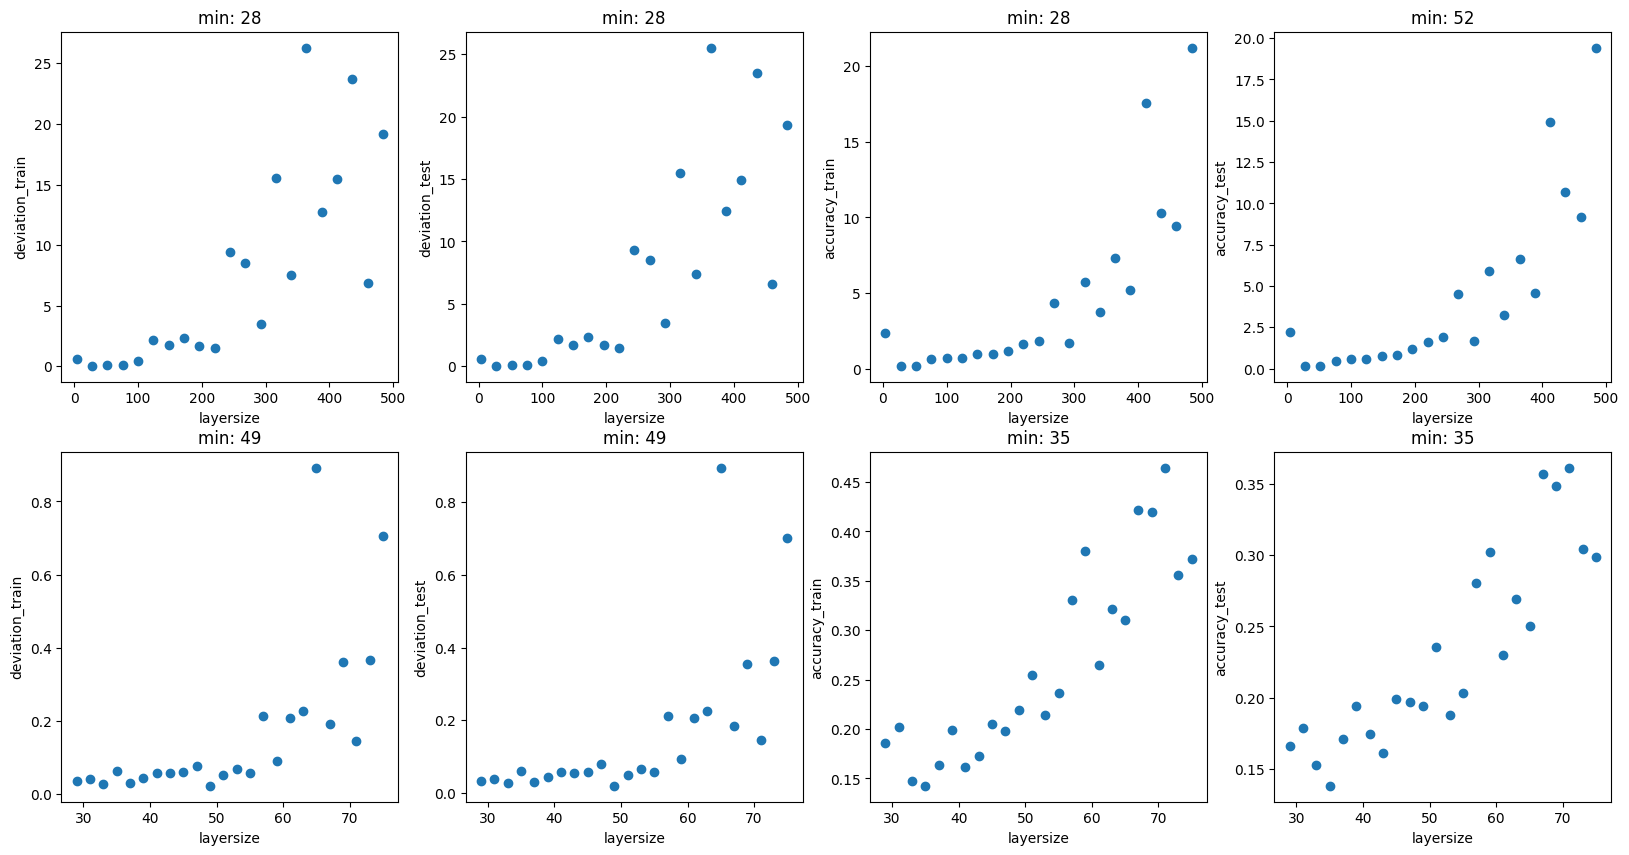

In [111]:
# find best layersize
num_dom = 250
num_bnd = 85
num_tst = 380
rcond = 1e-10
start = 4
stop = 500
points = 20
step = int((stop - start)/points)

res = []
metrics = ['deviation_train', 'deviation_test', 'accuracy_train', 'accuracy_test']
while step >= 1:
    layers = np.arange(start=start, stop=stop+1, step=step).reshape(-1, 1)
    res_step = {
        'layersizes' : layers,
        'deviation_train' : [],
        'deviation_test' : [],
        'accuracy_train' : [],
        'accuracy_test' : [],
        'min_l' : 0
        }
    for l in layers:
        r = run(num_dom, num_bnd, num_tst, l, rcond)
        res_step['deviation_train'].append(r['deviation'][0])
        res_step['deviation_test'].append(r['deviation'][1])
        res_step['accuracy_train'].append(r['accuracy'][0])
        res_step['accuracy_test'].append(r['accuracy'][1])
    res.append(res_step)
    min_l = layers[np.argmin(res_step['accuracy_test'])]
    res_step['min_l'] = min_l
    start = min_l - step + 1
    stop = min_l + step - 1
    step = int((stop - start)/points)


runs = len(res)
fig = plt.figure(figsize=(20, 10))
for r in range(runs):
    for idx, metric in enumerate(metrics):
        fig.add_subplot(runs, 4, r*4 + idx + 1)
        plt.xlabel("layersize")
        plt.ylabel(metric)
        min_l = res[r]["min_l"]
        layers = res[r]["layersizes"]
        min_l = layers[np.argmin(res[r][metric])]
        plt.title(f"min: {min_l[0]}")
        plt.scatter(res[r]["layersizes"], res[r][metric])

layers = res[-1]["layersizes"]
opt_layers: int = layers[np.argmin(res[-1]["accuracy_test"])]


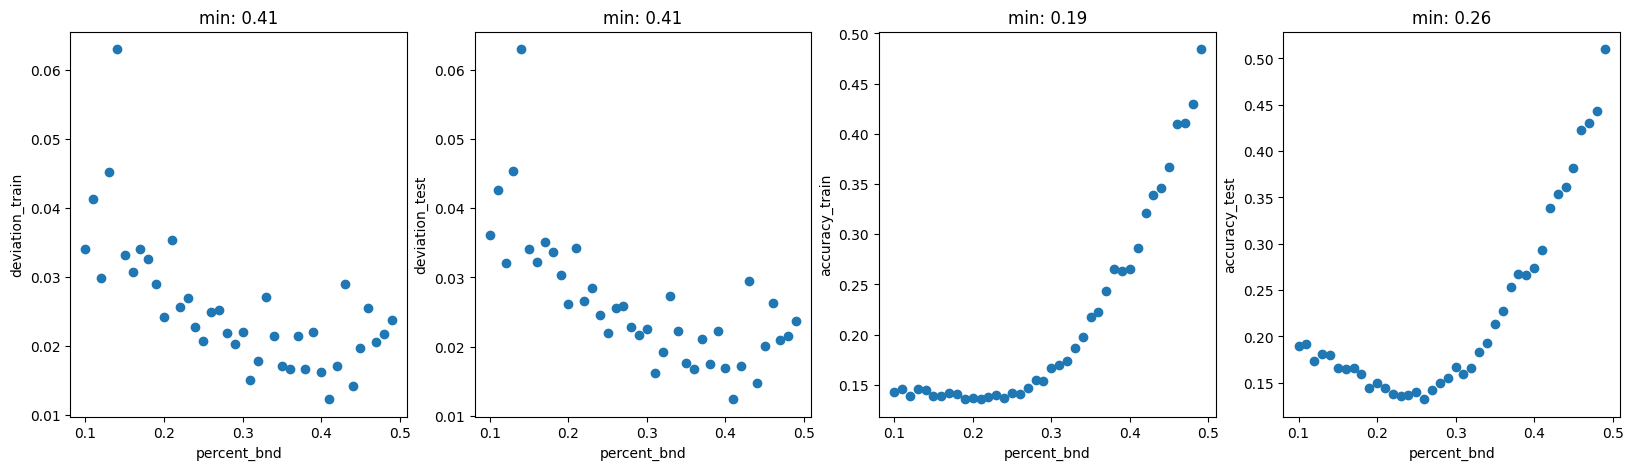

In [112]:
# find best ratio num_bnd/num_dom

num_data = 2000
num_tst = 300
layers = [opt_layers]
# percent of num_bnd
step = 0.01
start = 0.1
stop = 0.5
rcond = 1e-10

percents = np.arange(start, stop, step=step)
res = {
    'deviation_train' : [],
    'deviation_test' : [],
    'accuracy_train' : [],
    'accuracy_test' : [],
    }
metrics = ['deviation_train', 'deviation_test', 'accuracy_train', 'accuracy_test']

for p in percents:
    num_bnd = int(p * num_data)
    num_dom = num_data - num_bnd
    r = run(num_dom, num_bnd, num_tst, layers, rcond)
    res['deviation_train'].append(r['deviation'][0])
    res['deviation_test'].append(r['deviation'][1])
    res['accuracy_train'].append(r['accuracy'][0])
    res['accuracy_test'].append(r['accuracy'][1])

runs = len(res)
fig = plt.figure(figsize=(20, 5))
for idx, metric in enumerate(metrics):
    fig.add_subplot(1, 4, idx + 1)
    plt.xlabel("percent_bnd")
    plt.title("min: " + "{:.2f}".format(percents[np.argmin(res[metric])]))
    plt.ylabel(metric)
    plt.scatter(percents, res[metric])

opt_bnd_percent: float = percents[np.argmin(res['accuracy_test'])]

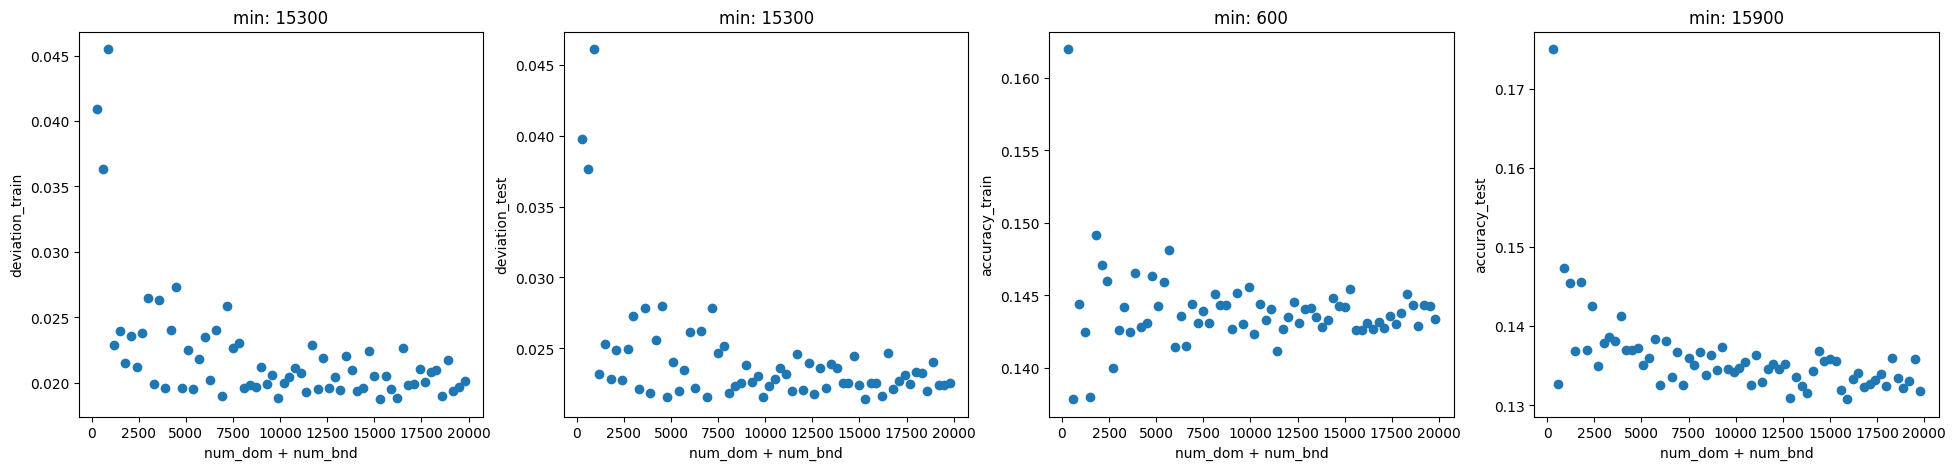

In [116]:
# find number of datapoints needed
start = 300
stop = 20_000
step = 300
num_data = np.arange(start, stop, step)
num_tst = 300
layers = [opt_layers]
bnd_per = opt_bnd_percent

res = {
    'deviation_train' : [],
    'deviation_test' : [],
    'accuracy_train' : [],
    'accuracy_test' : [],
    }
metrics = ['deviation_train', 'deviation_test', 'accuracy_train', 'accuracy_test']

for data in num_data:
    num_bnd = int(bnd_per * data)
    num_dom = data - num_bnd
    r = run(num_dom, num_bnd, num_tst, layers, rcond)
    res['deviation_train'].append(r['deviation'][0])
    res['deviation_test'].append(r['deviation'][1])
    res['accuracy_train'].append(r['accuracy'][0])
    res['accuracy_test'].append(r['accuracy'][1])

runs = len(res)
fig = plt.figure(figsize=(24, 5))
for idx, metric in enumerate(metrics):
    fig.add_subplot(1, 4, idx + 1)
    plt.xlabel("num_dom + num_bnd")
    plt.title(f"min: {num_data[np.argmin(res[metric])]}")
    plt.ylabel(metric)
    plt.scatter(num_data, res[metric])

opt_num_data: int = num_data[np.argmin(res['accuracy_test'])]

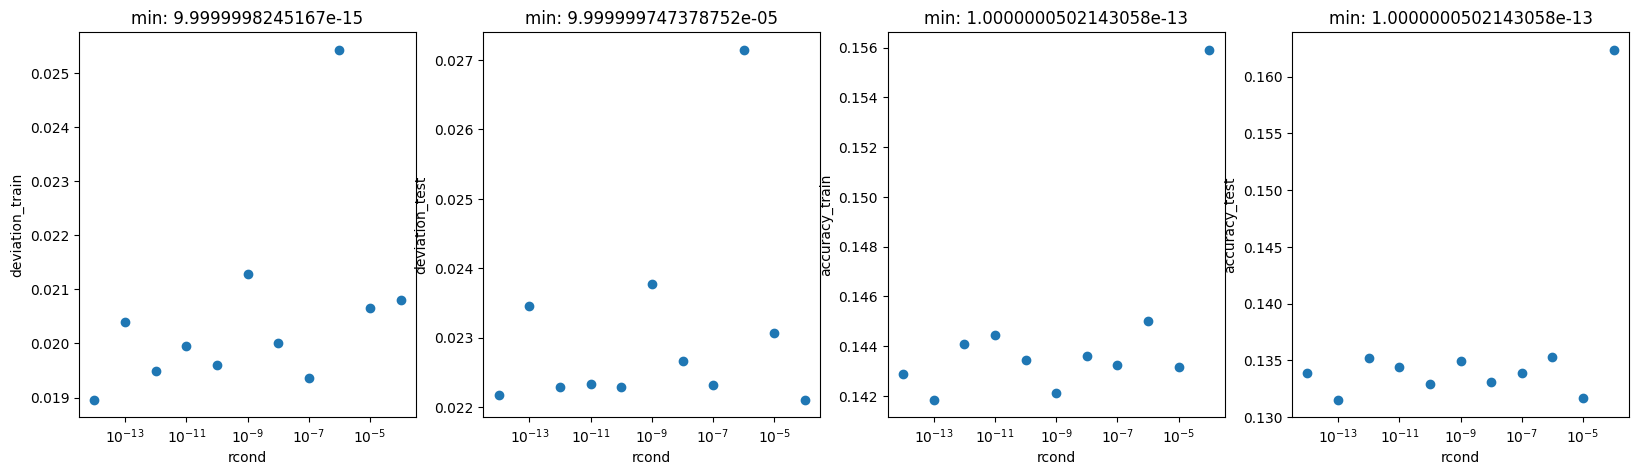

In [117]:
num_bnd = int(opt_bnd_percent * opt_num_data)
num_dom = opt_num_data - num_bnd
layers = opt_layers
num_tst = 340
rconds = np.arange(start=4, stop=15, step=1, dtype=DTYPE)
scale = lambda x: 1/(10**(x))
# scale = 1e-x
rconds = scale(rconds)

res = {
    'deviation_train' : [],
    'deviation_test' : [],
    'accuracy_train' : [],
    'accuracy_test' : [],
    }
metrics = ['deviation_train', 'deviation_test', 'accuracy_train', 'accuracy_test']

for rcond in rconds:
    r = run(num_dom, num_bnd, num_tst, layers, rcond)
    res['deviation_train'].append(r['deviation'][0])
    res['deviation_test'].append(r['deviation'][1])
    res['accuracy_train'].append(r['accuracy'][0])
    res['accuracy_test'].append(r['accuracy'][1])

fig = plt.figure(figsize=(20, 5))
for idx, metric in enumerate(metrics):
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.set_xscale("log")
    plt.xlabel("rcond")
    plt.title(f"min: {rconds[np.argmin(res[metric])]}")
    plt.ylabel(metric)
    plt.scatter(rconds, res[metric])

opt_rcond: float = rconds[np.argmin(res['accuracy_test'])]


In [119]:
# print optimum
num_bnd = int(opt_bnd_percent * opt_num_data)
num_dom = opt_num_data - num_bnd
num_tst = 340
rcond = opt_rcond

res = run(num_dom=num_dom, num_bnd=num_bnd, num_tst=num_tst, layers=opt_layers, rcond=rcond)
print("\n best parameteres found:")
print(f"layers: {opt_layers}\tnum_dom: {num_dom}\tnum_bnd: {num_bnd}\tr_cond: {opt_rcond}")
print(res)

layers: [35]	num_dom: 11767	num_bnd: 4133	r_cond: 1.0000000502143058e-13
{'accuracy': (0.1435300195999613, 0.13585231622277003), 'deviation': (0.018868699673409504, 0.021959838174839923)}
